In [4]:
import sys
!{sys.executable} -m pip install pymongo
!{sys.executable} -m pip install pyyaml
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install scipy
import os
print(os.getcwd())



/Users/drewgregory/JupyterNotebooks


In [3]:
# Get Mongo database
from yaml import load
from pymongo import MongoClient
secret = load(open("../.getsecret.yaml"))

client = MongoClient(secret["MONGODB_URI"])
db = client[secret["DB_NAME"]]

In [1]:
# Get all synced accounts and their respective users.
import urllib.request as req
import json
accounts = json.loads(req.urlopen("http://localhost:5000/synced_emails").read().decode("utf-8"))

In [21]:
# Organize sessions by goal and frequent vs. infrequent for Android
goals = {}
for account in accounts:
    for user in account["android"]:
        for session in db[user + "_sessions"].find({"enabled": True}):
            domain = session["domain"]
            if domain not in goals:
                goals[domain] = {"freq":[], "infreq":[]}
            if session["frequent"]:
                goals[domain]["freq"].append(session)
            else:
                goals[domain]["infreq"].append(session)

In [ ]:
import matplotlib.pyplot as pyplot
from statistics import mean, median
from scipy.stats import sem, norm 
# Now show graphs for each domain to compare frequent sessions vs infrequent sessions.
domain_stats = []
for domain in goals:
    if len(goals[domain]["freq"]) > 0 and len(goals[domain]["infreq"]) > 0:
        freq_durations = [session["duration"] for session in goals[domain]["freq"]]
        freq_avg = mean(freq_durations)
        freq_err = sem(freq_durations)
        infreq_durations = [session["duration"] for session in goals[domain]["infreq"]] 
        infreq_avg = mean(infreq_durations)
        infreq_err = sem(infreq_durations)
        domain_stats.append({"domain": domain, "freq": freq_avg, 
                             "infreq": infreq_avg, "freq_pts":len(goals[domain]["freq"]),
                            "infreq_pts":len(goals[domain]["infreq"]), "freq_err": freq_err,
                            "infreq_err": infreq_err})
        
domain_stats = sorted(domain_stats, key=lambda stat: int(stat["freq_pts"] + stat["infreq_pts"]))
counter = 0
for stat in domain_stats:
    print(int(stat["freq_pts"] + stat["infreq_pts"]))
    print(stat['domain'] + " with " + str(stat["freq_pts"]) + " freq points " + " and " + str(stat["infreq_pts"]) + " infreq pts")
    print("freq avg: " + str(stat["freq"]))
    print("infreq avg: " + str(stat["infreq"]))
    print("")
    # If there is a statistically significant difference (95% conf intervals don't overlap), we will show the graph.
    if stat["freq"] - 1.64 * stat["freq_err"] > stat["infreq"] + 1.64 * stat["infreq_err"] or stat["infreq"] -  1.64 * stat["infreq_err"] > stat["freq"] + 1.64 * stat["freq_err"]:
        pyplot.figure(counter)
        counter += 1
        pyplot.title(stat["domain"])
        pyplot.ylabel('Average session duration')
        pyplot.bar(["sessions with frequent setting", "sessions with infrequent setting"], [stat["freq"], stat["infreq"]] , .8, yerr=[1.64 * stat["freq_err"], 1.64 * stat["infreq_err"]])
    

In [4]:
improvement_stats = {"freq": [], "infreq": []}
for account in accounts:
    for user in account["android"]:
        # We now want to see if they have goals that have alternated from freq to infreq.
        goals={}
        for session in db[user + "_sessions"].find({"enabled": True}):
            domain = session["domain"]
            if domain not in goals:
                goals[domain] = {"freq_duration":0, "freq_count": 0, "infreq_duration":0, "infreq_count":0}
            if session["frequent"]:
                goals[domain]["freq_duration"] += session["duration"]
                goals[domain]["freq_count"] += 1
            else:
                goals[domain]["infreq_duration"] += session["duration"]
                goals[domain]["infreq_count"] += 1
        # Compute averages
        for domain in goals:
            if goals[domain]["freq_count"] > 0 and goals[domain]["infreq_count"] > 0:
                freq_avg = goals[domain]["freq_duration"]/goals[domain]["freq_count"]
                infreq_avg = goals[domain]["infreq_duration"]/goals[domain]["infreq_count"]
                improvement_stats["freq"].append(freq_avg)
                improvement_stats["infreq"].append(infreq_avg)


In [7]:
from scipy.stats import ttest_ind
print(str(len(improvement_stats["freq"])))
results = ttest_ind(improvement_stats["freq"], improvement_stats["infreq"])
print(str(results))

56
Ttest_indResult(statistic=-1.0560954661601163, pvalue=0.29323855646335867)


ValueError: could not convert string to float: 'POSITIVE_FULL_SCREEN_OVERLAY'

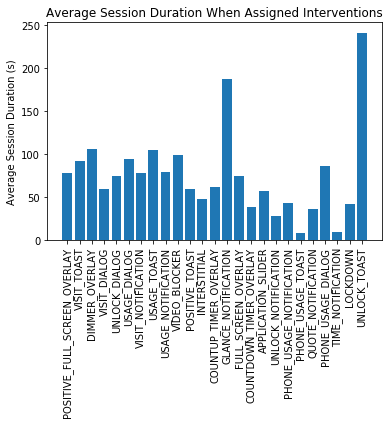

In [17]:
# Now let's analyze which interventions are most effective.
interventions = {}
for account in accounts:
    for user in account["android"]:
        for session in db[user + "_sessions"].find({"enabled": True}):
            if "interventions" in session:
                for intervention in session["interventions"]:
                    intervention_name = intervention["intervention"]
                    if intervention_name not in interventions:
                        interventions[intervention_name] = {"total": 0, "count": 0}
                    interventions[intervention_name]["total"] += session["duration"]
                    interventions[intervention_name]["count"] += 1 
pyplot.figure(counter)
counter += 1
pyplot.title('Average Session Duration When Assigned Interventions')
pyplot.ylabel('Average Session Duration (s)')
pyplot.xticks(rotation=90)
pyplot.bar([name for name in interventions], [interventions[name]["total"]/interventions[name]["count"] for name in interventions])


In [ ]:
# Let's get the distribution of session lengths (hopefully log-norm for LMM)
import math
session_durations = []
for account in accounts:
    for user in account["android"]:
        for session in db[user + "_sessions"].find():
            if session["duration"] > 5 and "interventions" in session:
                session_durations.append({"frequent": session["frequent"], "duration": math.log(session["duration"]), "interventions": session["interventions"], "user": user, "goal": session["domain"]})
pyplot.figure(counter)
counter += 1
pyplot.hist([session["duration"] for session in session_durations], bins=50)
from scipy.stats import shapiro
print(shapiro([session["duration"] for session in session_durations]))

In [27]:
#Ehh.... our Shapiro test didn't fare too well, but we'll export to a CSV and let Geza run an LMM anyway.
import csv
with open('sessions_for_intervention.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['frequent', 'duration (log(s))', 'interventions', 'user', 'goal'])
    for session in session_durations:
        writer.writerow([session[name] for name in session])

In [33]:
# Now, let's see which version is responsible for the super low sessions (it was a bug)
version_counts = {}
for account in accounts:
    for user in account["android"]:
        for session in db[user + "_sessions"].find({"enabled": True, "version": {"$exists": True}}):
            version = session["version"]
            if version not in version_counts:
                version_counts[version] = {"small": 0, "all": 0}
            version_counts[version]["all"] += 1
            if session["duration"] < 1:
                version_counts[version]["small"] += 1
print([str(version) + ":" + str(version_counts[version]["small"]/version_counts[version]["all"]) + " " for version in version_counts])


['21:0.023616734143049933 ', '24:0.0201765447667087 ', '18:0.005291005291005291 ', '20:0.021695257315842584 ', '27:0.10934182590233546 ', '28:0.06923751095530237 ', '25:0.06279069767441861 ', '29:0.1951219512195122 ', '23:0.041666666666666664 ', '32:0.075990675990676 ', '31:0.2764505119453925 ', '26:0.1794871794871795 ']


In [24]:
# Now, let's do some clean up.
# ABORT: VERY FEW HABITLAB SESSIONS First, we should remove 0-length sessions. They really shouldn't happen.
# Next, we should also remove sessions that are longer than a day. That was because of a bug in my code.
"""
done = False
for account in accounts:
    if not done:
        for user in account["android"]:
            if not done:
                print("USER ---- " + user)
                if len([s for s in db[user + "_sessions"].find({"duration": {"$gt": 60 ** 2 * 24}})]) > 0:
                    print("Num of sessions: " + str(len([s for s in db[user+"_sessions"].find()])))
                    print("Num of bad sessions: " + str(len([s for s in db[user + "_sessions"].find({"domain": "", "duration": {"$gt": 60 ** 2 * 24}})])))
                    db[user + "_sessions"].delete_many({"domain": "","duration": {"$gt": 60 ** 2 * 24}})
                    print("After delete: " + str(len([s for s in db[user+"_sessions"].find()])))


"""


USER ---- 9cb8c59eabbb60ad6447345c
USER ---- b219926d16e6e46fa426cafd
USER ---- U1532437453047928
Num of sessions: 2031
Num of bad sessions: 500
After delete: 1531
USER ---- 010cf6179f52b3d62184ee17
Num of sessions: 5053
Num of bad sessions: 1041
After delete: 4012
USER ---- 0b0d1da5c036cb9637aff5d5
Num of sessions: 2089
Num of bad sessions: 368
After delete: 1721
USER ---- f6c5e87bbe828ffc4278d4b7
USER ---- 38a4b3e06ead18a13442f5a7
Num of sessions: 1586
Num of bad sessions: 443
After delete: 1143
USER ---- f463f9d5191a4bc1d1374298
Num of sessions: 72
Num of bad sessions: 20
After delete: 52
USER ---- c4f80e629327886902828290
USER ---- ec0dbd76f4093d26176ba153
Num of sessions: 818
Num of bad sessions: 208
After delete: 610
USER ---- 855de136c8e71443d24b081b
USER ---- c8dc7f9f2901e94fd90b9a05
USER ---- 3d9e01f13145754f3ee22cdb
Num of sessions: 3359
Num of bad sessions: 663
After delete: 2696
USER ---- 0cb53f687a648364e24cb0da
USER ---- c9991373fd8cd5ce69292511
Num of sessions: 1866
Num 

Num of sessions: 247
Num of bad sessions: 52
After delete: 195
USER ---- fe0378a1fa1878aee2e3710c
Num of sessions: 1304
Num of bad sessions: 241
After delete: 1063
USER ---- b9bd67f8294ab1c12ad34307
Num of sessions: 43
Num of bad sessions: 5
After delete: 38
USER ---- b19b3e921de096e4f3251208
Num of sessions: 92
Num of bad sessions: 12
After delete: 80
USER ---- 74ac5a869bf3b4e86b8674af
USER ---- abfd029cb3f787f0a8f09dae
Num of sessions: 6110
Num of bad sessions: 239
After delete: 5871
USER ---- 24dd98db148d8dae05123d5f
USER ---- 07a9b87976916d467512cc52
Num of sessions: 1375
Num of bad sessions: 479
After delete: 896
USER ---- 421619f90f941a563deb6eb9
Num of sessions: 5213
Num of bad sessions: 617
After delete: 4596
USER ---- a06f3a950a4d20e8dafb1aee
Num of sessions: 2689
Num of bad sessions: 254
After delete: 2435
USER ---- b5b6e353511a2a14537988ff
Num of sessions: 883
Num of bad sessions: 187
After delete: 696
USER ---- bfa5332a5b2a4fdde8975897
USER ---- ad12374c25e20347657dc216
Num

Num of sessions: 1094
Num of bad sessions: 136
After delete: 958
USER ---- f425b912351840fc002aa901
USER ---- b0bb9bbfa279f214f4a2052d
Num of sessions: 104
Num of bad sessions: 23
After delete: 81
USER ---- a8887a6e2070ced6342a832d
Num of sessions: 573
Num of bad sessions: 93
After delete: 480
USER ---- a3c75afed38512390aca34b6
USER ---- 6377acce2a54e6971d4702f6
Num of sessions: 294
Num of bad sessions: 51
After delete: 243
USER ---- 8b1a629b98c777872a7bfdbd
Num of sessions: 340
Num of bad sessions: 57
After delete: 283
USER ---- 708dbfaebbbba9065074286d
USER ---- dc3b87df83232926790040ec
USER ---- 8986fee529fbb0d9d7088af3
USER ---- c6c086cbeedcb01530ed214a
Num of sessions: 392
Num of bad sessions: 135
After delete: 257
USER ---- 42a5c2bd41f829b48818af38
USER ---- 9cc8c74f9d40ea67c67843cc
USER ---- ea6c441c96df6073aebea4c5
Num of sessions: 958
Num of bad sessions: 93
After delete: 865
USER ---- 42031f51af2f72490147713e
Num of sessions: 415
Num of bad sessions: 83
After delete: 332
USER

In [18]:
# Find number of users who didn't make it past onboarding.
num_users = 0
num_quit_users = 0
collections = db.list_collection_names()
for account in accounts:
    for user in account["android"]:
        num_users += 1
        if user+"_sessions" not in collections:
            num_quit_users += 1
print("Total Android users: " + str(num_users))
print("Android users who didn't make it past onboarding: " + str(num_quit_users))
print("% of quitters: " + str(num_quit_users/num_users))

Total Android users: 259
Android users who didn't make it past onboarding: 75
% of quitters: 0.28957528957528955


In [ ]:
# Analyze conservation within Android



In [ ]:
ANDROID = "android"
BROWSER = "browser"
# Associate users with domain name
def getName(name, device):
    """
    @param name: goal name (package name for Android)
    @param device: "android" or "browser"
    @return name of goal with subdomains removed and goal annotation removed (i.e. spend_less_time)
    """
    if device == ANDROID:
        
    

In [ ]:
# Analyze conservation across devices
for account in accounts:
    for